In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#Using our merged dataset (train & val), alongside our given test data

This Task is task 1 (MEL VS NEVUS AND SEB). PLEASE USE APPROPRIATE PATH TO TASK1

In [3]:
#please set title for saving model correctly!!!
title = "mel_vs_nev&seb_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 5s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [9]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Replace the loss function in your model with focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2) # configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                   #configuring learnining rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [12]:
#function for plot graph for training and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC scorecalculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels) # classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged_augumented/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [15]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [16]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

Traning for Fold: 1
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.5327
Epoch 1: val_accuracy improved from -inf to 0.61923, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_1.hdf5
104/104 [==============================] - 88s 331ms/step - loss: 0.1680 - accuracy: 0.5327 - val_loss: 0.1173 - val_accuracy: 0.6192 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.5788
Epoch 2: val_accuracy did not improve from 0.61923
104/104 [==============================] - 31s 296ms/step - loss: 0.1134 - accuracy: 0.5788 - val_loss: 0.1110 - val_accuracy: 0.5692 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to

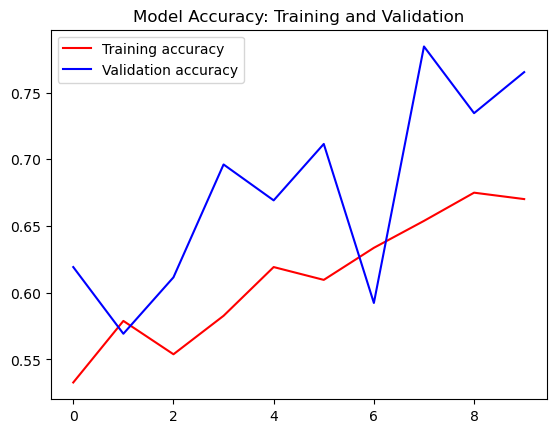

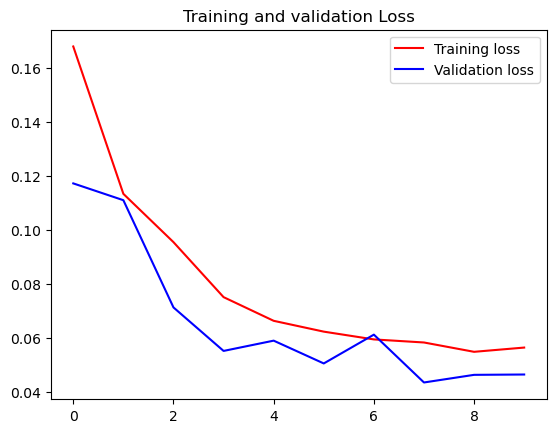

<Figure size 640x480 with 0 Axes>

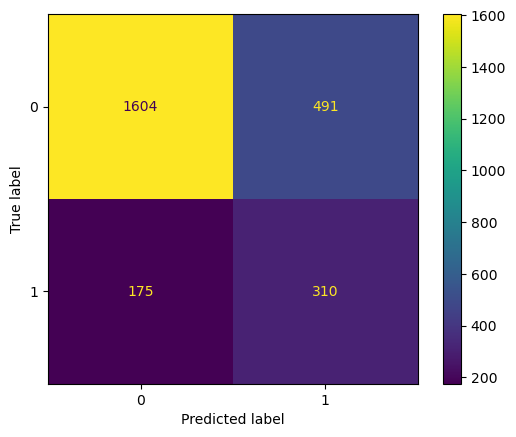


               precision    recall  f1-score   support

           0       0.90      0.77      0.83      2095
           1       0.39      0.64      0.48       485

    accuracy                           0.74      2580
   macro avg       0.64      0.70      0.66      2580
weighted avg       0.80      0.74      0.76      2580

Sensitivity: 0.639 Specificity: 0.766 Precision: 0.805 ROC_AUC_SCORE: 0.779



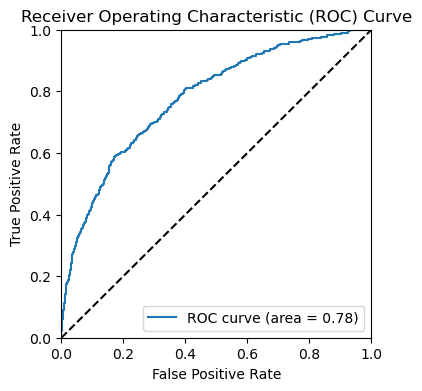

Validation complete...
Traning for Fold: 2
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.6712
Epoch 1: val_accuracy improved from -inf to 0.83077, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_2.hdf5
104/104 [==============================] - 82s 354ms/step - loss: 0.0568 - accuracy: 0.6712 - val_loss: 0.0397 - val_accuracy: 0.8308 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.7048
Epoch 2: val_accuracy did not improve from 0.83077
104/104 [==============================] - 33s 319ms/step - loss: 0.0531 - accuracy: 0.7048 - val_loss: 0.0421 - val_accuracy: 0.7731 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler s

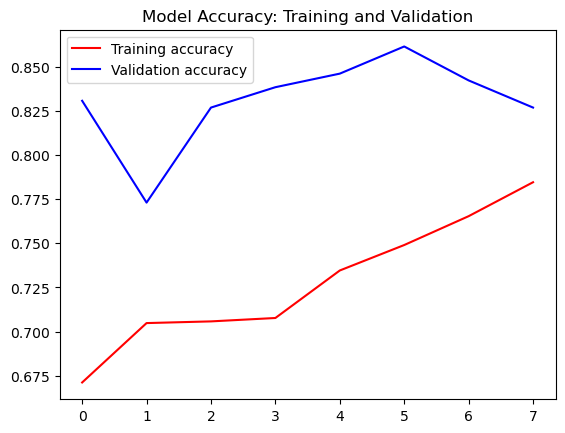

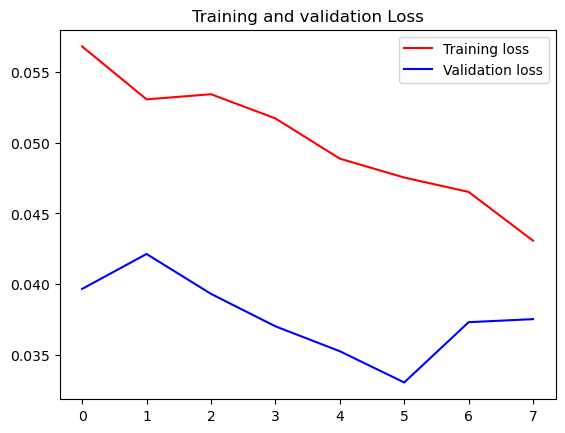

<Figure size 640x480 with 0 Axes>

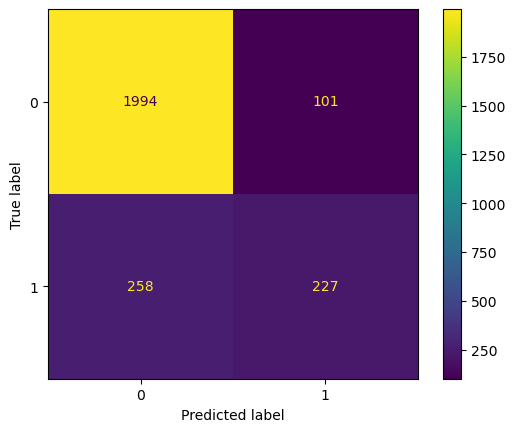


               precision    recall  f1-score   support

           0       0.89      0.95      0.92      2095
           1       0.69      0.47      0.56       485

    accuracy                           0.86      2580
   macro avg       0.79      0.71      0.74      2580
weighted avg       0.85      0.86      0.85      2580

Sensitivity: 0.468 Specificity: 0.952 Precision: 0.849 ROC_AUC_SCORE: 0.833



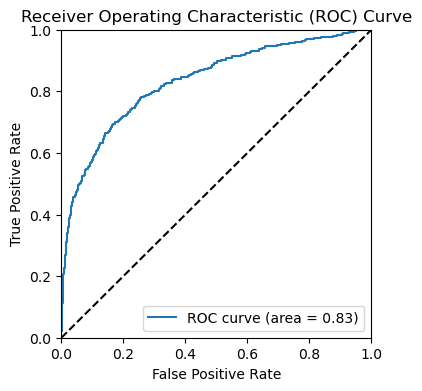

Validation complete...
Traning for Fold: 3
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.7490
Epoch 1: val_accuracy improved from -inf to 0.83462, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_3.hdf5
104/104 [==============================] - 83s 363ms/step - loss: 0.0480 - accuracy: 0.7490 - val_loss: 0.0361 - val_accuracy: 0.8346 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.7577
Epoch 2: val_accuracy improved from 0.83462 to 0.85000, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_3.hdf5
104/104 [==============================] - 34s 327ms/step - loss: 0.0455 - accuracy: 0.7577 - val_loss: 

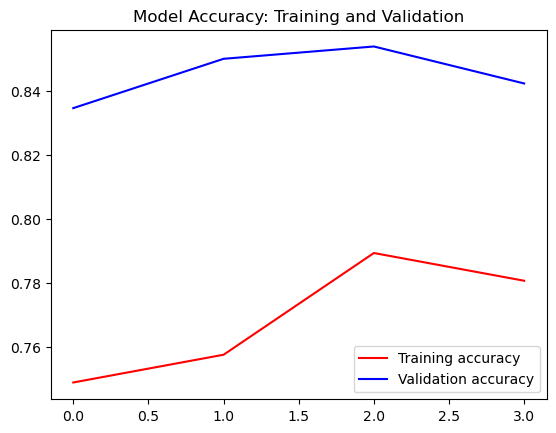

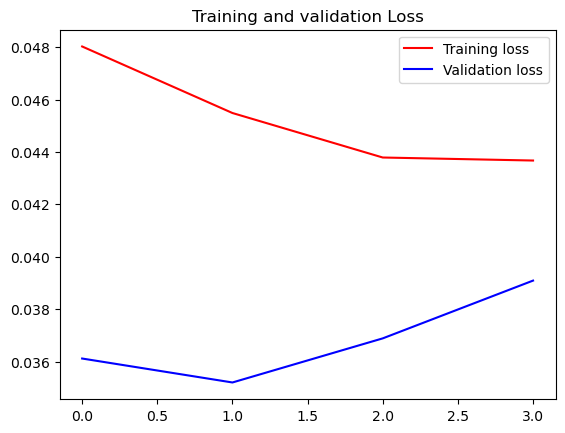

<Figure size 640x480 with 0 Axes>

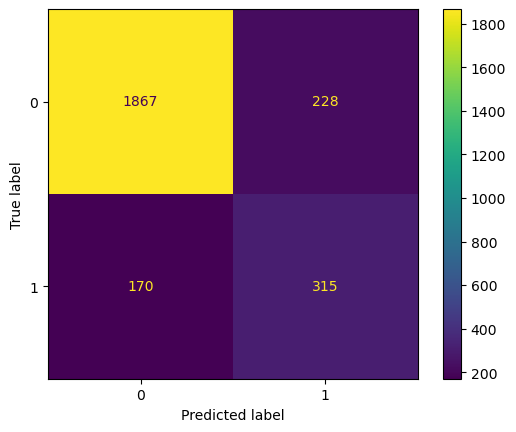


               precision    recall  f1-score   support

           0       0.92      0.89      0.90      2095
           1       0.58      0.65      0.61       485

    accuracy                           0.85      2580
   macro avg       0.75      0.77      0.76      2580
weighted avg       0.85      0.85      0.85      2580

Sensitivity: 0.649 Specificity: 0.891 Precision: 0.853 ROC_AUC_SCORE: 0.865



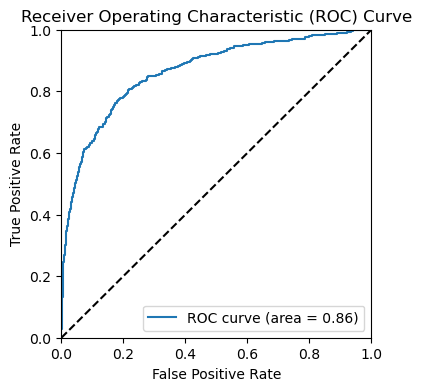

Validation complete...
Traning for Fold: 4
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.7490
Epoch 1: val_accuracy improved from -inf to 0.84231, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_4.hdf5
104/104 [==============================] - 81s 334ms/step - loss: 0.0460 - accuracy: 0.7490 - val_loss: 0.0388 - val_accuracy: 0.8423 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.7923
Epoch 2: val_accuracy improved from 0.84231 to 0.86538, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_4.hdf5
104/104 [==============================] - 34s 330ms/step - loss: 0.0433 - accuracy: 0.7923 - val_loss: 

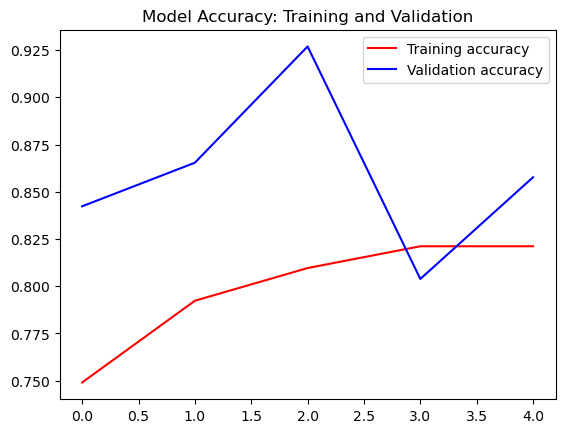

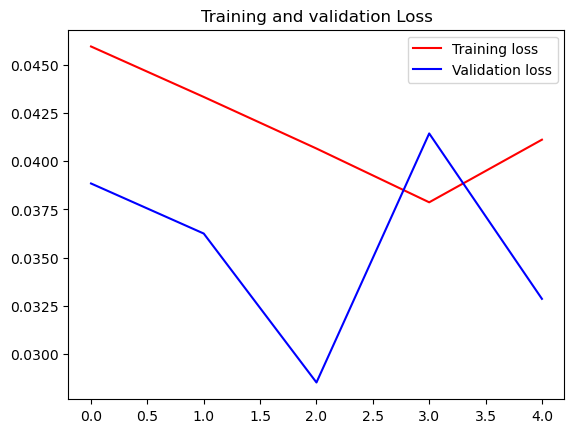

<Figure size 640x480 with 0 Axes>

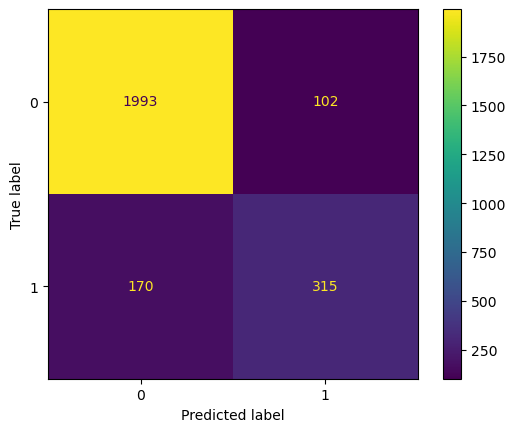


               precision    recall  f1-score   support

           0       0.92      0.95      0.94      2095
           1       0.76      0.65      0.70       485

    accuracy                           0.89      2580
   macro avg       0.84      0.80      0.82      2580
weighted avg       0.89      0.89      0.89      2580

Sensitivity: 0.649 Specificity: 0.951 Precision: 0.89 ROC_AUC_SCORE: 0.897



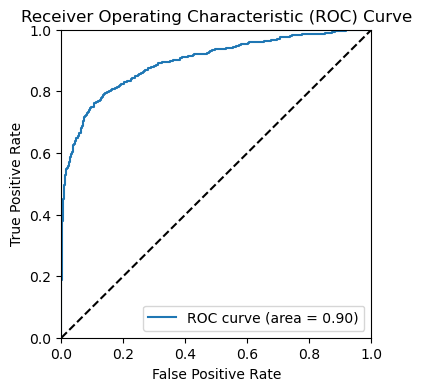

Validation complete...
Traning for Fold: 5
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.8346
Epoch 1: val_accuracy improved from -inf to 0.87308, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_5.hdf5
104/104 [==============================] - 83s 357ms/step - loss: 0.0397 - accuracy: 0.8346 - val_loss: 0.0300 - val_accuracy: 0.8731 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.8394
Epoch 2: val_accuracy improved from 0.87308 to 0.90000, saving model to /kaggle/working/model/mel_vs_nev&seb_aug/model_fold_5.hdf5
104/104 [==============================] - 32s 305ms/step - loss: 0.0384 - accuracy: 0.8394 - val_loss: 

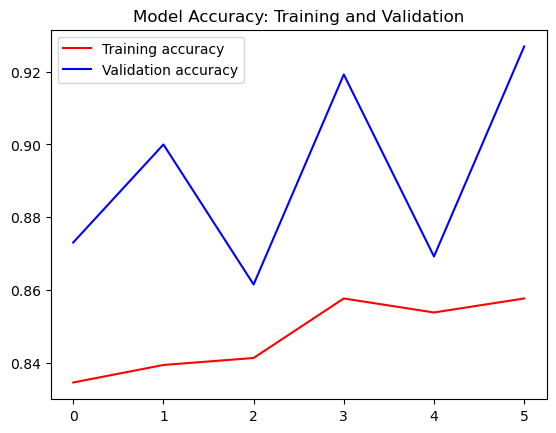

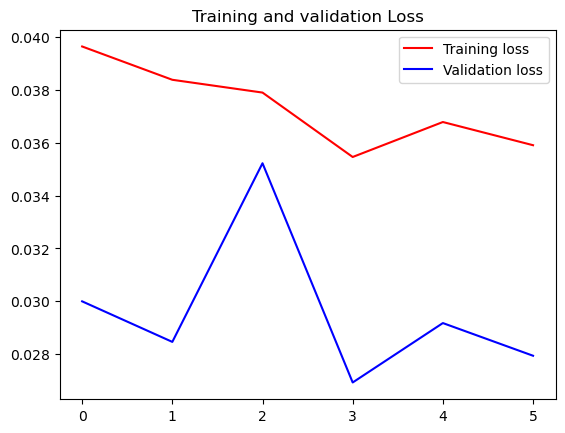

<Figure size 640x480 with 0 Axes>

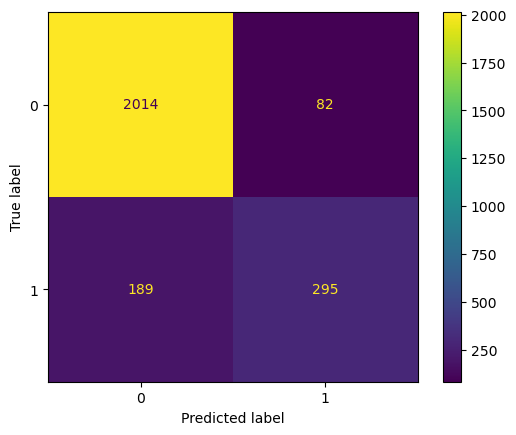


               precision    recall  f1-score   support

           0       0.91      0.96      0.94      2096
           1       0.78      0.61      0.69       484

    accuracy                           0.89      2580
   macro avg       0.85      0.79      0.81      2580
weighted avg       0.89      0.89      0.89      2580

Sensitivity: 0.61 Specificity: 0.961 Precision: 0.889 ROC_AUC_SCORE: 0.902



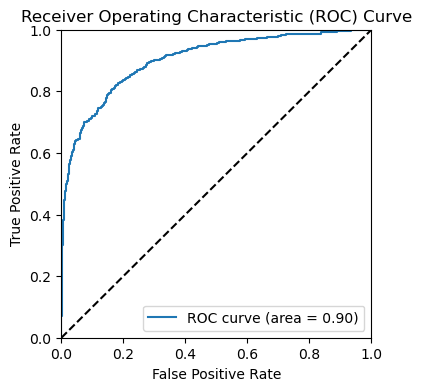

Validation complete...


In [18]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=10,
        callbacks=callbacks)

    #plotting graph for training and validation accuracy and loss
    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [19]:
test_dir

'/kaggle/input/isic-2017-merged/test/test/task1'

In [20]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 20s 33ms/step


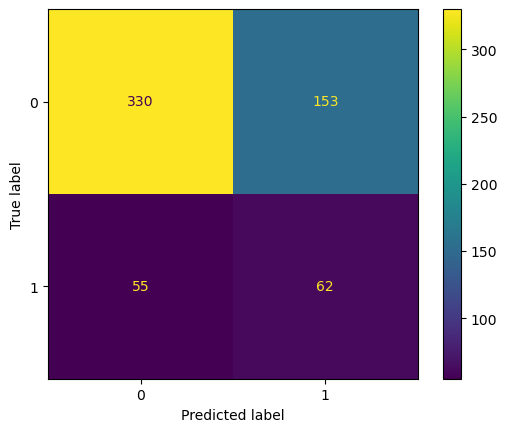


               precision    recall  f1-score   support

           0       0.86      0.68      0.76       483
           1       0.29      0.53      0.37       117

    accuracy                           0.65       600
   macro avg       0.57      0.61      0.57       600
weighted avg       0.75      0.65      0.68       600

Sensitivity: 0.53 Specificity: 0.683 Precision: 0.746 ROC_AUC_SCORE: 0.659



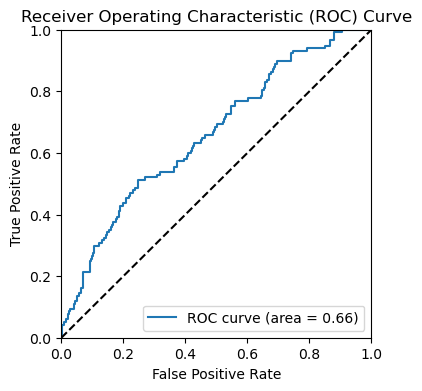

Testing Complete
Test using model 2
600/600 [==============================] - 19s 32ms/step


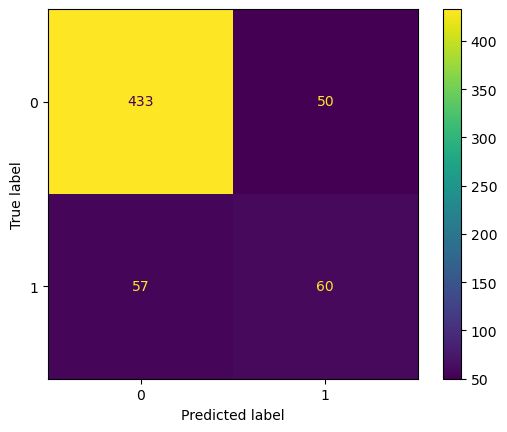


               precision    recall  f1-score   support

           0       0.88      0.90      0.89       483
           1       0.55      0.51      0.53       117

    accuracy                           0.82       600
   macro avg       0.71      0.70      0.71       600
weighted avg       0.82      0.82      0.82       600

Sensitivity: 0.513 Specificity: 0.896 Precision: 0.818 ROC_AUC_SCORE: 0.794



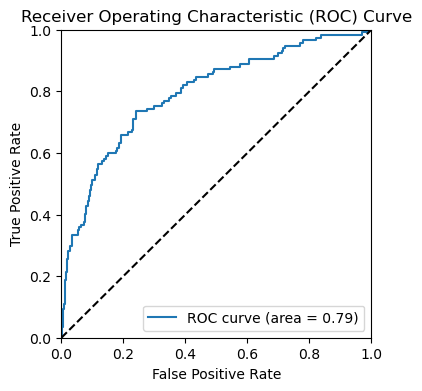

Testing Complete
Test using model 3
600/600 [==============================] - 19s 32ms/step


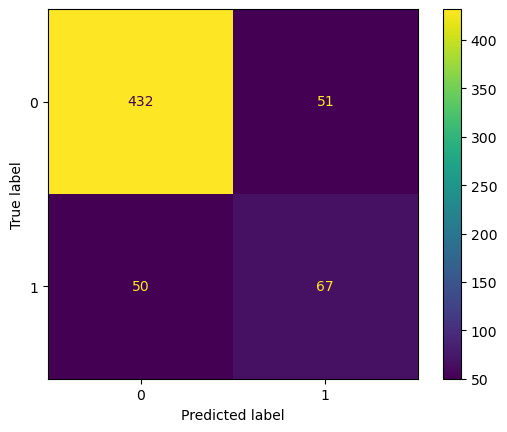


               precision    recall  f1-score   support

           0       0.90      0.89      0.90       483
           1       0.57      0.57      0.57       117

    accuracy                           0.83       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.83      0.83      0.83       600

Sensitivity: 0.573 Specificity: 0.894 Precision: 0.832 ROC_AUC_SCORE: 0.775



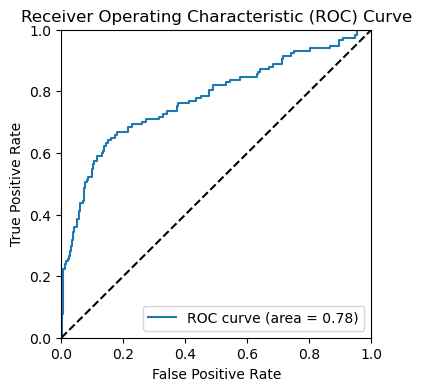

Testing Complete
Test using model 4
600/600 [==============================] - 20s 32ms/step


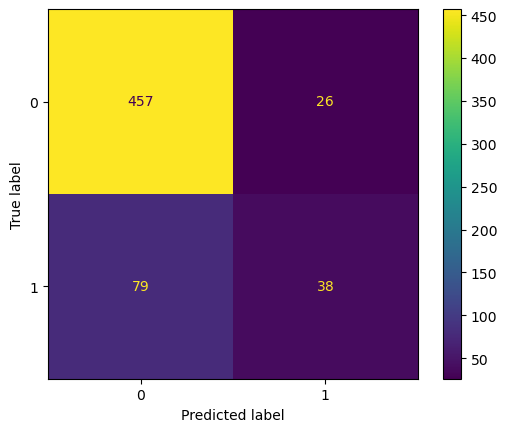


               precision    recall  f1-score   support

           0       0.85      0.95      0.90       483
           1       0.59      0.32      0.42       117

    accuracy                           0.82       600
   macro avg       0.72      0.64      0.66       600
weighted avg       0.80      0.82      0.80       600

Sensitivity: 0.325 Specificity: 0.946 Precision: 0.802 ROC_AUC_SCORE: 0.76



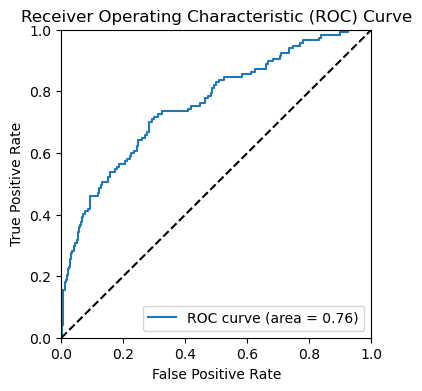

Testing Complete
Test using model 5
600/600 [==============================] - 19s 32ms/step


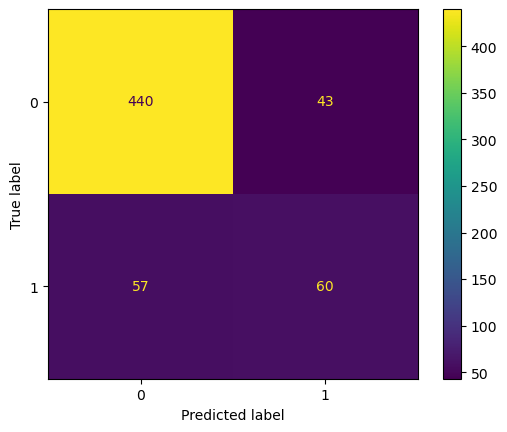


               precision    recall  f1-score   support

           0       0.89      0.91      0.90       483
           1       0.58      0.51      0.55       117

    accuracy                           0.83       600
   macro avg       0.73      0.71      0.72       600
weighted avg       0.83      0.83      0.83       600

Sensitivity: 0.513 Specificity: 0.911 Precision: 0.826 ROC_AUC_SCORE: 0.814



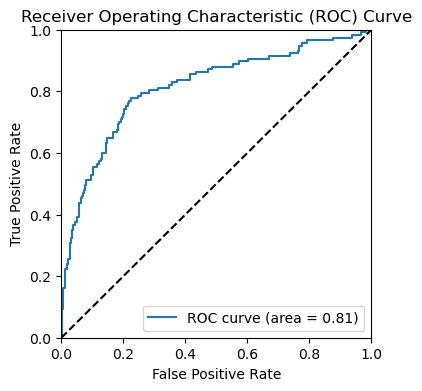

Testing Complete


In [21]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")